In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [2]:
dataset_path = "/kaggle/input/inaturalist-12k/inaturalist_12K/"

In [3]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [4]:
train_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=transform)
val_dataset = datasets.ImageFolder(root = dataset_path + "val", transform=transform)

In [5]:
print(len(train_dataset))
print(len(val_dataset))

9999
2000


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
print(len(train_loader))
print(len(val_loader))

313
63


In [8]:
# class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
classpath = pathlib.Path(dataset_path + "train")
class_names = sorted([j.name.split('/')[-1] for j in classpath.iterdir()])

In [9]:
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [10]:
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(6, 6, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Transpose the image tensor to (height, width, channels) for displaying
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.show()

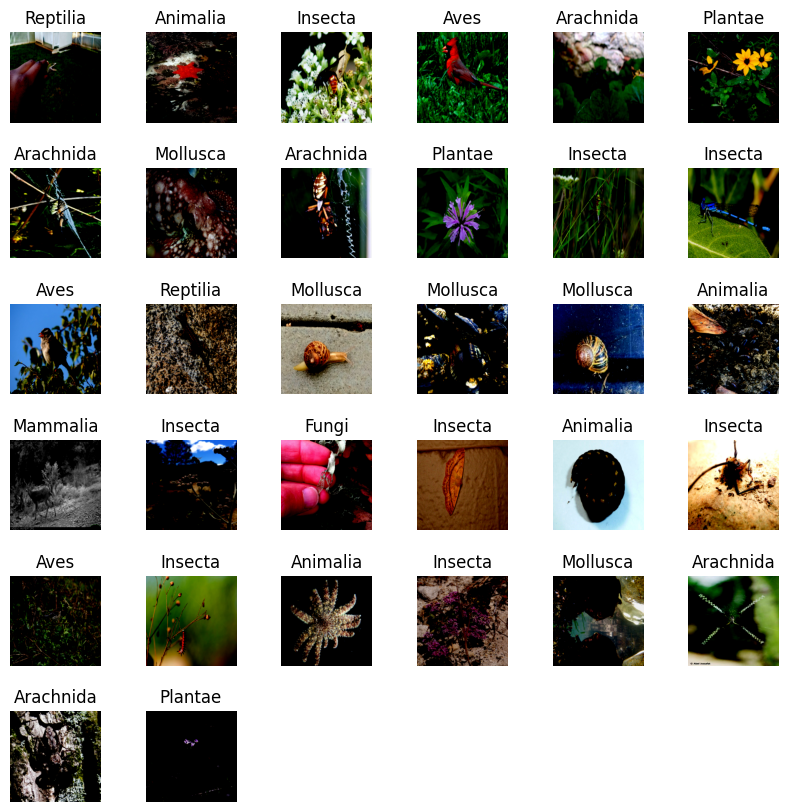

In [11]:
for images, labels in train_loader:
  show_images(images, labels)
  break

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
class SmallCNN(nn.Module):
  def __init__(self, num_classes):
    super(SmallCNN, self).__init__()

    # Defining convolution layers

    # input: 3 x 256 x 256
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    # no. of parameters: 3 x 3 x 3 x 16 = 432

    # after applying maxpooling: input: 16 x 128 x 128
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    # no. of parameters: 16 x 3 x 3 x 32 = 4,608

    # after applying maxpooling: input: 32 x 64 x 64
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    # no. of parameters: 32 x 3 x 3 x 64 = 18,432

    # after applying maxpooling: input: 64 x 32 x 32
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    # no. of parameters: 64 x 3 x 3 x 128 = 73,728

    # after applying maxpooling: input: 128 x 16 x 16
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    # no. of parameters: 128 x 3 x 3 x 256 = 2,94,912

    # Defining maxpooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining fully connected layer
    self.fc1 = nn.Linear(256 * 8 * 8, 512)              # The final maxpooling will give the output as 256 * 8 * 8 where D = 256, W = 8, H = 8
    # no. of parameters: (256 * 8 * 8 * 512) + 512 = 8389120

    self.fc2 = nn.Linear(512, num_classes)
    # no. of parameters: (512 * 10) + 10 = 5130


  def forward(self, x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = self.pool(nn.functional.relu(self.conv3(x)))
    x = self.pool(nn.functional.relu(self.conv4(x)))
    x = self.pool(nn.functional.relu(self.conv5(x)))

    x = x.view(-1, 256 * 8 * 8)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [14]:
model = SmallCNN(num_classes=10)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [16]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 1
# for epoch in tqdm(range(num_epochs)):
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     for inputs, labels in tqdm(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()  # Zero the gradients
#         outputs = model(inputs)  # Forward pass
#         loss = criterion(outputs, labels)  # Compute the loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Update the parameters
#         running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(train_loader.dataset)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

# Set model to training mode
model.train()

# Number of iterations (batches) to train on
num_iterations = 1

# Training loop
for epoch in range(num_iterations):
    for inputs, labels in tqdm(train_loader):
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print or log loss
        print(f'Batch Loss: {loss.item()}')

        # Break out of the loop after processing the first batch
        break

  0%|          | 0/313 [00:01<?, ?it/s]

Batch Loss: 2.301060676574707
